<a href="https://colab.research.google.com/github/hugomedsa/valuation_acoes_b3/blob/main/Passo_5_%5BEm_constru%C3%A7%C3%A3o%5D_Crescimento_estimado_com_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance -q
!pip install unidecode -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
import os
from google.colab.data_table import DataTable

import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
codigosb3 = pd.read_csv('/content/drive/MyDrive/codigos.csv')

def readhug(link):
  dem_juntos = pd.read_csv(link)
  dem_juntos['DS_CONTA'] = dem_juntos['DS_CONTA'].str.lower()
  dem_juntosfc = dem_juntos
  dem_juntosfc['GRUPO_DFP'] = dem_juntosfc['GRUPO_DFP'].apply(lambda x: x[16:].strip())
  dem_juntosfc['DS_CONTA'] = dem_juntosfc['DS_CONTA'].str.lower()
  return [dem_juntos,dem_juntosfc]

In [ ]:
codigosb3

In [ ]:
#codigos = pd.read_csv('https://gist.githubusercontent.com/ianliu/a146d77e704da78dfaf086e04383b72c/raw/4f27fd077b5e6b5a08ffd5d3228e7fa19bcdb222/codigos.csv')

ano_itr, ano_dfp = 2023, 2022

conta, tri = 'dfp', 3   #'itr' or 'dfp'
if conta == 'itr':
  #ind = readhug(f'/content/drive/MyDrive/ITR_{ano_itr}/itr_ind_filtrado.csv')
  con = readhug(f'/content/drive/MyDrive/ITR_{ano_itr}/itr_con_filtrado.csv')
else:
  #ind = readhug(f'/content/drive/MyDrive/DFP_{ano_dfp}/dfp_ind_filtrado.csv')
  con = readhug(f'/content/drive/MyDrive/DFP_{ano_dfp}/dfp_con_filtrado.csv')

##Estimando o crescimento do lucro anual consolidado

In [ ]:
con[0].head(3)

,DT_REFER,DENOM_CIA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2010-12-31,BCO BRASIL S.A.,1023,Balanço Patrimonial Ativo,ÚLTIMO,1,ativo total,802819794.0
1,2010-12-31,BCO BRASIL S.A.,1023,Balanço Patrimonial Ativo,ÚLTIMO,1.01,caixa e equivalentes de caixa,25219700.0
2,2010-12-31,BCO BRASIL S.A.,1023,Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,caixa e depósitos bancários,9816675.0


In [ ]:
ticker = 'SLCE3'.upper()

In [ ]:
codigosb3.sample(4)

,Unnamed: 0,ticker,setor,segmento,CD_CVM
675,675,PGMN3,Comércio e Distribuição,Medicamentos e Outros Produtos,22608.0
560,560,LUXM3,Transporte,Transporte Hidroviário,8192.0
585,585,MLAS3,Computadores e Equipamentos,Computadores e Equipamentos,26034.0
332,332,DUFB11,Comércio,Produtos Diversos,NaN


In [ ]:
codigo = codigosb3['CD_CVM'][(codigosb3['ticker'] == ticker)].iloc[0]

def filt(dem_juntos,dem_juntosfc):
  dem_empresa = dem_juntos[(dem_juntos['CD_CVM'] == codigo) & (dem_juntosfc['GRUPO_DFP'] != 'Demonstração do Fluxo de Caixa (Método Indireto)')
                            & dem_juntos['CD_CONTA'].isin(['1','1.01.01','2.01','2.01.02','2.01.04','2.01.04.01','2.01.04.02','2.01.04.03','2.02.01','2.02.01.01',
                                                           '2.02.01.02','2.02.01.03','2.03','2.05','2.07','3.01','3.05','3.08','3.11','3.11.01','3.13'])]
  dem_empresafcl = dem_juntosfc[(dem_juntosfc['CD_CVM'] == codigo) & (dem_juntosfc['GRUPO_DFP'] == 'Demonstração do Fluxo de Caixa (Método Indireto)')]
  return [dem_empresa, dem_empresafcl]

#empresa_ind = filt(ind[0],ind[1])
empresa_con = filt(con[0],con[1])

In [ ]:
empresa_con[0].head(5)

,DT_REFER,DENOM_CIA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
21711,2010-12-31,SLC AGRICOLA S.A.,20745,Balanço Patrimonial Ativo,ÚLTIMO,1,ativo total,3116573.0
21713,2010-12-31,SLC AGRICOLA S.A.,20745,Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,caixa e equivalentes de caixa,725.0
45141,2011-12-31,SLC AGRICOLA S.A.,20745,Balanço Patrimonial Ativo,ÚLTIMO,1,ativo total,3584453.0
45143,2011-12-31,SLC AGRICOLA S.A.,20745,Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,caixa e equivalentes de caixa,130463.0
68030,2012-12-31,SLC AGRICOLA S.A.,20745,Balanço Patrimonial Ativo,ÚLTIMO,1,ativo total,3715631.0


In [ ]:
dem_conta = empresa_con[0][['CD_CONTA','DS_CONTA']].drop_duplicates().set_index('CD_CONTA')

In [ ]:
def tabelar(dados,indice):
  dem_agrup = pd.pivot_table(dados[['DT_REFER',indice,'VL_CONTA']],
                                  columns=['DT_REFER'],
                                  values=['VL_CONTA'],
                                  index=indice,
                                  fill_value=0)
  dem_pf = dem_agrup.T
  dem_pf.reset_index(level=0, inplace=True)
  dem_p = dem_pf.dropna()
  del dem_p['level_0']

  return dem_p

# dem_to = tabelar(empresa_ind[0],'CD_CONTA')
# dem_fcl = tabelar(empresa_ind[1],'DS_CONTA')
dem_toc = tabelar(empresa_con[0],'CD_CONTA')
dem_fclc = tabelar(empresa_con[1],'DS_CONTA')

In [ ]:
dem_fclc.head(2)

DS_CONTA,adiantamento a fornecedores,adiantamento de clientes,adiantamentos de clientes,adição de propriedade para investimento,ajustes de avaliação patrimonial,amortização de direito de uso,aplicações financeiras,aplicações financeiras de curto prazo,aquisição de investimento em controladora,arrendamentos a pagar,...,valor justo propriedades para investimentos,variação ativo biológico,variação cambial s/ caixa e equivalentes,variação dos ativos biologicos,variação dos ativos biológicos,variações dos ativos biológicos,variações nos ativos e passivos,venda (recompra de ações),venda ou recompra de açoes,venda ou recompra de ações
DT_REFER,,,,,,,,,,,,,,,,,,,,,
2010-12-31,0.0,0.0,0.0,0.0,17591.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8950.0,0.0,0.0,0.0
2011-12-31,0.0,56738.0,0.0,0.0,-75033.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-34103.0,0.0,0.0,0.0,0.0,112460.0,0.0,0.0,0.0


In [ ]:
prices = yf.download(f'{ticker}.SA',start='2010-01-01')[['Close']]
# base de dados: https://docs.google.com/spreadsheets/d/1PNhGNtVK_FZWA59Dn7Kxnz6Dn9L-MalHPF6S3e0FbSQ/edit#gid=0
sheet_google=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQQx8tapMpcdj0BUaRb8rWJQ1CbgEUU-YmLYd71pDsHPaWPkPTLfF5coZAr-cCz6OtsLa73ZF9UavYk/pub?output=csv')

for i,ticket in enumerate(sheet_google['ticker']):
  if codigosb3['ticker'][i] != ticket:
    print('Colunas desiguais. Copie os tickets da variável codigosb3 para a planilha do Google Sheet')
    break

dem_mkt = sheet_google.set_index('ticker')
def price(dem_v):
  ano_atual = max(ano_itr, ano_dfp)
  prices_median = {'PRICES':[]}
  for ano in range(ano_atual-len(dem_v),ano_atual):
    if 'dfp' not in conta: #Utilizo o preço de três meses após o trimestre, para evitar a defasagem na entrega dos balanços e reduzir a volatilidade
      if tri == 9:
        a = prices.loc[f'{ano}-{tri+3}':f'{ano}-{tri+3}','Close'].median() # tri+3
      else:
        a = prices.loc[f'{ano}-0{tri+3}':f'{ano}-0{tri+3}','Close'].median() # tri+3
      prices_median['PRICES'].append(float(a))

    else:
      a = prices.loc[f'{ano}-03':f'{ano}-03','Close'].median()
      prices_median['PRICES'].append(float(a))

  dem_v['PRICES'] = prices_median['PRICES']
  dem_vp = dem_v.dropna()
  dem_vp['shares'] = dem_mkt.loc[ticker.upper(),'marketcap']/ float(dem_mkt.loc[ticker.upper(),'price'].replace(',','.')) #SE O GOOGLE FINANCE DER "ZERO", USA O BACKUP 'marketcap2' e 'price2, ATÉ NORMALIZAR O SISTEMA.
  dem_vp['MARKET_CAP'] = dem_vp['shares'].copy() * dem_vp['PRICES'].copy()
  return dem_vp
#dem_t1 = price(dem_to)
dem_tc1 = price(dem_toc)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
DataTable(dem_conta,num_rows_per_page=25)

,DS_CONTA
CD_CONTA,
1,ativo total
1.01.01,caixa e equivalentes de caixa
2.01,passivo circulante
2.01.02,fornecedores
2.01.04,empréstimos e financiamentos
2.01.04.01,empréstimos e financiamentos
2.01.04.02,debêntures
2.01.04.03,financiamento por arrendamento financeiro
2.02.01,empréstimos e financiamentos


In [ ]:
import unidecode
def valuation(dem_t,dfcl):
  dem_t['patliq'] = dem_t['lucro'] = dem_t['divbruta'] = 0
  for c in dem_t.index:
    # -------------------------------------------------------------------------------------------------
    if '2.07' in dem_t.columns:
      if dem_t.loc[c, '2.07'] != 0:
        dem_t.loc[c,'patliq'] = dem_t.loc[c, '2.07']
      elif dem_t.loc[c, '2.05'] != 0:
        dem_t.loc[c,'patliq'] = dem_t.loc[c, '2.05']
      else:
        dem_t.loc[c,'patliq'] = dem_t.loc[c, '2.03']
    elif '2.05' in dem_t.columns:
      if dem_t.loc[c, '2.05'] != 0:
        dem_t.loc[c,'patliq'] = dem_t.loc[c, '2.05']
      else:
        dem_t.loc[c,'patliq'] = dem_t.loc[c, '2.03']
    else:
      dem_t.loc[c,'patliq'] = dem_t.loc[c, '2.03']
    # -------------------------------------------------------------------------------------------------
    if '3.13' in dem_t.columns:
      if dem_t.loc[c, '3.13'] != 0:
        dem_t.loc[c,'lucro'] = dem_t.loc[c, '3.13']
      else:
        dem_t.loc[c,'lucro'] = dem_t.loc[c, '3.11']
    else:
      if '3.11' in dem_t.columns:
        dem_t.loc[c,'lucro'] = dem_t.loc[c, '3.11']
    # -------------------------------------------------------------------------------------------------
    if '3.13' in dem_t.columns and dem_t['3.13'].median() != 0: #provisões de duvidosos e sinistros
      prov = ['3.02.03','3.02.04','3.02.05','3.04.01']
      provisoes = []
      for x in prov:
        if x in dem_t.columns:
          provisoes.append(i)
      min = dem_t[provisoes].loc[c].astype(float).min()
      dem_t.loc[c, 'divbruta'] = min
    elif '2.01.04' in dem_t.columns:
      if dem_t.loc[c, '2.02.01'] + dem_t.loc[c, '2.01.04'] == 0: #dividas não financeiras
        dem_t.loc[c, 'divbruta'] = dem_t.loc[c, '2.01.04.01'] + dem_t.loc[c, '2.02.01.01'] + dem_t.loc[c, '2.01.04.02'] + dem_t.loc[c, '2.02.01.02'] + dem_t.loc[c, '2.01.04.03'] + dem_t.loc[c, '2.02.01.03'] # empréstimos + debêntures + arrendamentos
      else:
        dem_t.loc[c, 'divbruta'] = dem_t.loc[c, '2.01.04'] + dem_t.loc[c, '2.02.01']
    else:
      dem_t.loc[c, 'divbruta'] = 0
  # -------------------------------------------------------------------------------------------------
  dem_t['divbruta'] = abs(dem_t['divbruta'])*-1
  dem_t['ROE'] = dem_t['lucro'] / dem_t['patliq']
  dem_t['L/P'] = dem_t['lucro'] / dem_t['MARKET_CAP']
  dem_t['VPA/P'] = dem_t['patliq'] / dem_t['MARKET_CAP']
  dem_t['NOPAT'] = dem_t['3.05'] + dem_t['3.08'] #Resultado Antes do Resultado Financeiro e dos Tributos-Imposto de Renda e Contribuição Social Diferidos
  try:
    dem_t['CAP_INVEST'] = dem_t['1'] - dem_t['1.01.01'] - dem_t['2.01'] #  (Ativo Total – Caixa e Equivalentes de Caixa – Passivo Circulante)
  except KeyError:
    dem_t['1.01.01'] = 0
    dem_t['CAP_INVEST'] = dem_t['1'] - dem_t['1.01.01'] - dem_t['2.01']
  try:
    dem_t['CAP_INVEST2'] = dem_t['1'] - dem_t['2.01.02'] - dem_t['1.01.01'] # (Ativo Total - Fornecedores - Caixa e Equivalentes de Caixa)
  except KeyError:
    dem_t['2.01.02'] = 0
    dem_t['CAP_INVEST2'] = dem_t['1'] - dem_t['2.01.02'] - dem_t['1.01.01']
  dem_t['CAP_INVEST3'] = dem_t['patliq'] + abs(dem_t['divbruta'])
  dem_t['ROIC1'] = dem_t['NOPAT'] / dem_t['CAP_INVEST']
  dem_t['ROIC2'] = dem_t['3.05'] / dem_t['CAP_INVEST2']
  dem_t['ROIC3'] = dem_t['3.05'] / dem_t['CAP_INVEST3']
  a = dem_t['ROIC1'] + dem_t['ROIC2'] + dem_t['ROIC3']
  dem_t['ROIC'] = a / 3
  dem_t['EV'] = dem_t['MARKET_CAP'] - dem_t['1.01.01'] + abs(dem_t['divbruta'])
  dem_t['EBIT/EV'] = dem_t['3.05'] / dem_t['EV']
  if '3.13' in dem_t.columns:
    if dem_t['3.13'].median() != 0:
      dem_t['EBIT/EV'] = dem_t['L/P']
      dem_t['ROIC'] = dem_t['ROE']
      dem_t['3.05'] = dem_t['lucro']
  fcl = pd.DataFrame()
  repos = pd.DataFrame()
  for coluna in dfcl.columns:
    c = unidecode.unidecode(coluna)
    if 'imobilizado' in c or 'intangive' in c or 'atividades operacionais' in c or 'aquisicao' in c or 'compra' in c or 'adicao' in c or 'adicoes' in c:
      if 'custo' not in c and 'constituic' not in c and 'provis' not in c and 'baixa' not in c and 'perda' not in c and 'venda' not in c and 'fornecedor' not in c and 'alienac' not in c and 'controlad' not in c and 'acoes' not in c and 'societ' not in c and 'empresa' not in c and 'financei' not in c and 'outros invest' not in c and 'ganho' not in c and 'provent' not in c and 'subsid' not in c and 'empresa' not in c and 'investimento' not in c and 'juro' not in c and "recuperave" not in c and "participacao" not in c and "distrato" not in c and "debenture" not in c and 'amortizac' not in c and 'a pagar' not in c and 'agio' not in c:
        fcl = fcl.join(dfcl[coluna], how='outer')
    if "depreciac" in c or "amortizac" in c and "divid" not in c:
      if 'debenture' not in c and 'agio' not in c and 'juro' not in c and 'emprestimo' not in c and 'contrato' not in c and 'credito' not in c and 'contas a receber' not in c and 'investimento' not in c and 'direito' not in c and "passivo" not in c and 'arrendamento' not in c and 'captac' not in c:
        repos = repos.join(dfcl[coluna], how='outer')
  dem_t['FCL'] = fcl.sum(axis=1)
  dem_t['Deprec+Amort'] = repos.sum(axis=1)
  if 'caixa líquido das atividades operacionais' in dfcl.columns:
    caixa = 'caixa líquido das atividades operacionais'
  else:
    caixa = 'caixa líquido atividades operacionais'
  dem_t['Capex/Deprec.'] = abs(dem_t['FCL'] - dfcl[caixa]) / dem_t['Deprec+Amort']
  dem_t['Ebitda/Div.Liq.'] = (dem_t['3.05']+ dem_t['Deprec+Amort'])/abs(abs(dem_t['divbruta']) - dem_t['1.01.01'])
  dem_t['PL/Div.Br.'] = dem_t['patliq']/abs(dem_t['divbruta'])
  dem_t['ML'] = dem_t['lucro'] / dem_t['3.01']
  anos = dem_t.index[:4:-1]
  colunas = ['patliq','lucro','3.05','ROE','ROIC','FCL']
  return [dem_t,fcl,repos]
#dem_indf = valuation(dem_t1,dem_fcl)
dem_conf = valuation(dem_tc1,dem_fclc)

In [ ]:
dem_conf[0].columns

Index(['1', '1.01.01', '2.01', '2.01.02', '2.01.04', '2.01.04.01',
       '2.01.04.02', '2.01.04.03', '2.02.01', '2.02.01.01', '2.02.01.02',
       '2.02.01.03', '2.03', '3.01', '3.05', '3.08', '3.11', '3.11.01',
       'PRICES', 'shares', 'MARKET_CAP', 'patliq', 'lucro', 'divbruta', 'ROE',
       'L/P', 'VPA/P', 'NOPAT', 'CAP_INVEST', 'CAP_INVEST2', 'CAP_INVEST3',
       'ROIC1', 'ROIC2', 'ROIC3', 'ROIC', 'EV', 'EBIT/EV', 'FCL',
       'Deprec+Amort', 'Capex/Deprec.', 'Ebitda/Div.Liq.', 'PL/Div.Br.', 'ML'],
      dtype='object', name='CD_CONTA')

#PREVISÃO SIMPLES

In [ ]:
tabela_previsao = dem_conf[0][['3.01','EBIT/EV','Capex/Deprec.','Ebitda/Div.Liq.','PL/Div.Br.','FCL','lucro']]

In [ ]:
tabela_previsao

CD_CONTA,3.01,EBIT/EV,Capex/Deprec.,Ebitda/Div.Liq.,PL/Div.Br.,FCL,lucro
DT_REFER,,,,,,,
2010-12-31,888713,0.067477,2.814617,0.458636,4.170423,13287.0,58613
2011-12-31,1005640,0.101075,6.027915,0.639512,3.000223,-92735.0,159992
2012-12-31,1118743,0.064200,1.476032,0.386976,2.458655,-130470.0,38430
2013-12-31,1181520,0.059033,2.281858,0.330454,1.826055,-305898.0,96603
2014-12-31,1499175,0.074684,1.821105,0.302826,1.796585,-106332.0,70143
2015-12-31,1761581,0.108530,1.332809,0.333188,1.273241,132484.0,121171
2016-12-31,1659649,0.046809,0.929779,0.256420,1.382718,208729.0,15641
2017-12-31,2219901,0.228383,2.016141,0.700629,1.700145,187123.0,369262
2018-12-31,2823468,0.149177,2.297651,0.703710,1.741202,151939.0,406501


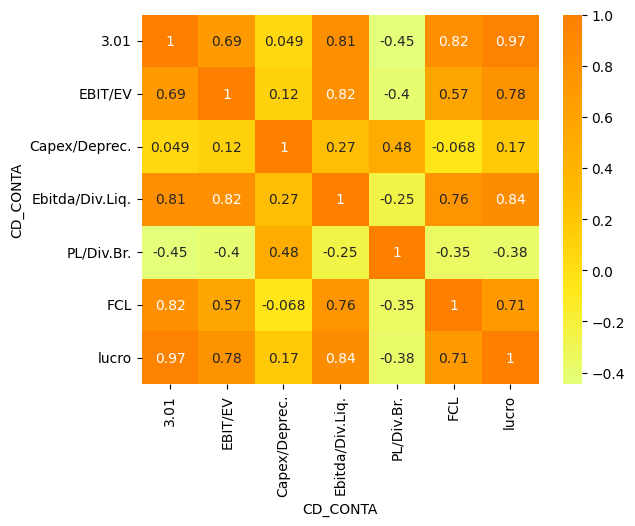

In [ ]:
sns.heatmap(tabela_previsao.corr(), cmap = 'Wistia', annot = True)
plt.show()

O gráfico mostra que o lucro tem forte correlação com a receita bruta de vendas, mas não com o indicador Patrimônio Lucro/Divida Bruta, o que sugere um efeito defasado nos investimentos ou utilização do patrimônio para distribuição de rendimentos. As variáveis independentes não apresentam alta correlação entre si, excetuando a Receita e a mesma relação PL/DB. Precisa-se atentar para essa relação no modelo.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

In [ ]:
x = tabela_previsao.drop('lucro', axis = 1)
y = tabela_previsao['lucro'].copy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split (x,y,test_size = 0.3)

# ----------------------------------------------

lin_reg = LinearRegression()
lin_reg.fit (x_train, y_train)

rf_reg = RandomForestRegressor()
rf_reg.fit (x_train, y_train)

# ----------------------------------------------

test_pred_lin = lin_reg.predict(x_test)
test_pred_rf = rf_reg.predict(x_test)

r2_lin = metrics.r2_score(y_test, test_pred_lin)
rmse_lin = np.sqrt(metrics.mean_squared_error(y_test, test_pred_lin))

print(f"R² da Regressão Linear: {r2_lin}")
print(f"RSME da Regressão Linear: {rmse_lin}")

r2_rf=metrics.r2_score(y_test, test_pred_rf)
rmse_rf=np.sqrt(metrics.mean_squared_error(y_test, test_pred_rf))

print(f"R² da Random Forest: {r2_rf}")
print(f"RSME do Random Forest: {rmse_rf}")

R² da Regressão Linear: 0.9443579567309544
RSME da Regressão Linear: 35873.12918398216
R² da Random Forest: 0.3374372853106772
RSME do Random Forest: 123788.762950831


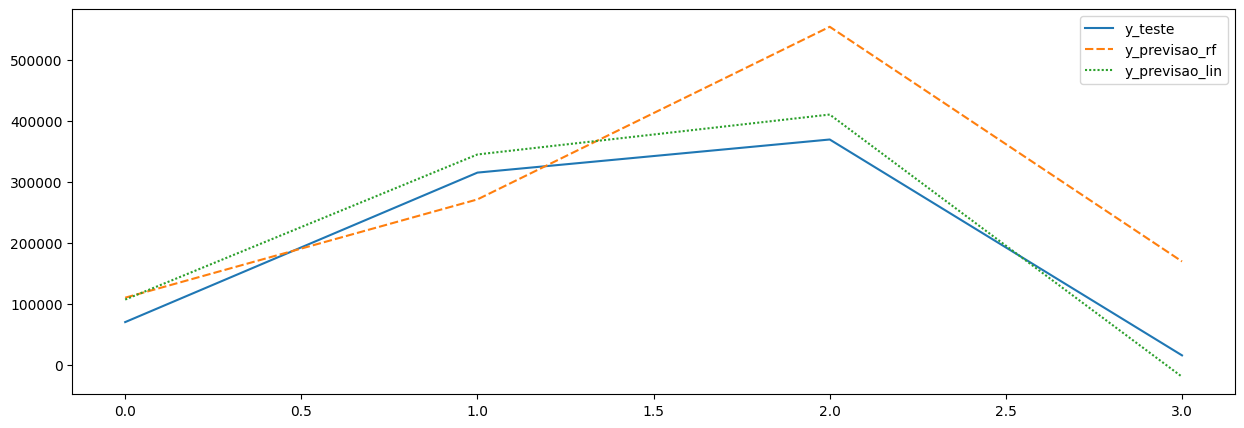

,y_teste,y_previsao_rf,y_previsao_lin
0,70143,110114.25,107054.153602
1,315041,271139.00,344755.492529
2,369262,553928.80,410142.133471
3,15641,169484.16,-19443.981841


In [ ]:
df_resultado = pd.DataFrame()
df_resultado['y_teste'] = y_test
df_resultado['y_previsao_rf'] = test_pred_rf
df_resultado['y_previsao_lin'] = test_pred_lin
df_resultado = df_resultado.reset_index(drop=True)
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data=df_resultado)
plt.show()
display(df_resultado)

#PREVISÃO DE VÁRIOS MODELOS

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Carregar os dados em um DataFrame (substitua 'dados.csv' pelo nome do seu arquivo de dados)
dados = tabela_previsao

# Dividir os dados em conjunto de treinamento e conjunto de teste
X = dados[['3.01','PL/Div.Br.','FCL']] #'Capex/Deprec.', 'Ebitda/Div.Liq.',,'EBIT/EV',
y = dados['lucro']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir os modelos
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('K Neighbors', KNeighborsRegressor()),
    ('Support Vector Regression', SVR()),
    ('XG Booster', XGBRegressor())
]

# Treinar e avaliar os modelos
for name, model in models:
    pipeline = Pipeline([('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(name + ":")
    print("MSE:", mse)
    print("R2 Score:", r2)
    print("------------------------------")


Linear Regression:
MSE: 21136666120.023624
R2 Score: 0.8988487091553012
------------------------------
Decision Tree:
MSE: 132461098067.66667
R2 Score: 0.36609629067482574
------------------------------
Random Forest:
MSE: 127051441687.03313
R2 Score: 0.3919846556052329
------------------------------
Gradient Boosting:
MSE: 144653809673.33658
R2 Score: 0.30774704530153163
------------------------------
K Neighbors:
MSE: 113253796147.46667
R2 Score: 0.4580144471068638
------------------------------
Support Vector Regression:
MSE: 339200318513.79565
R2 Score: -0.6232716114155588
------------------------------
XG Booster:
MSE: 134269474209.47209
R2 Score: 0.3574421547747896
------------------------------


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# Carregar os dados em um DataFrame (substitua 'dados.csv' pelo nome do seu arquivo de dados)
dados = tabela_previsao

# Dividir os dados em conjunto de treinamento e conjunto de teste
X = dados[['3.01', 'EBIT/EV', 'Capex/Deprec.', 'Ebitda/Div.Liq.', 'PL/Div.Br.', 'FCL']]
y = dados['lucro']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir os modelos
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('K Neighbors', KNeighborsRegressor()),
    ('Support Vector Regression', SVR()),
    ('XG Booster', XGBRegressor())
]

# Criar a figura
fig = go.Figure()

# Plotar o lucro real até 2021
fig.add_trace(go.Scatter(x=dados.index, y=dados['lucro'], name='Lucro Real'))

# Plotar as previsões para cada modelo
for name, model in models:
    pipeline = Pipeline([('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # Prever o lucro até 2026
    years_future = pd.date_range(start='2022-01-01', end='2026-01-01', freq='Y')
    X_future = pd.DataFrame(index=years_future, columns=X.columns)
    X_future.fillna(X.mean(), inplace=True)
    y_future = pipeline.predict(X_future)

    # Plotar as previsões
    fig.add_trace(go.Scatter(x=years_future, y=y_future, mode='lines', name=name))

    # Anotar o valor de R2
    fig.add_annotation(xref='paper', yref='paper', x=1.05, y=0.5, text=f"R2: {r2:.2f}", showarrow=False, align='left')

# Configurar o layout do gráfico
fig.update_layout(title='Projeções de Lucro',
                  xaxis_title='Ano',
                  yaxis_title='Lucro',
                  legend=dict(x=0, y=1),
                  xaxis=dict(range=['2010-01-01', '2026-01-01']),
                  xaxis_tickangle=-45,
                  margin=dict(l=50, r=50, t=50, b=50))

# Exibir o gráfico
fig.show()
